## 1. Instalar as bibliotecas necessárias

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
import subprocess
import numpy as np

## 2. Importar os arquivos no notebook

In [339]:
# Carregar arquivos excel

flights = pd.read_csv(r"C:\Users\Notebook\Documents\Laboratoria\flights_202301.csv")
airline_dict = pd.read_csv(r"C:\Users\Notebook\Documents\Laboratoria\AIRLINE_CODE_DICTIONARY.csv")
dot_dict = pd.read_excel(r"C:\Users\Notebook\Documents\Laboratoria\DOT_CODE_DICTIONARY.xlsx")

In [340]:
# conferir 

print(f"Shape of Voos: {flights.shape}")
print(f"Shape of Airline_dict: {airline_dict.shape}")
print(f"Shape of Dot_dict: {dot_dict.shape}")

Shape of Voos: (538837, 33)
Shape of Airline_dict: (1729, 2)
Shape of Dot_dict: (1737, 2)


## 3. Conferir informações iniciais

In [ ]:
# Ajustar nomes das colunas
airline_dict = airline_dict.rename(
    columns=lambda col: f"AIRLINE_{col}" if col != "Code" else col
)
dot_dict = dot_dict.rename(
    columns=lambda col: f"DOT_{col}" if col != "Code" else col
)

In [ ]:
airline_dict = airline_dict.rename(
    columns={"AIRLINE_AIRLINE_AIRLINE_{col}": "AIRLINE_Description"}
)

dot_dict = dot_dict.rename(
    columns={"DOT_{col}": "DOT_Description"}
)

In [ ]:
# Ver dimensões
print("Voos:", flights.shape)
print("Airline dict:", airline_dict.shape)
print("DOT dict:", dot_dict.shape)

In [ ]:
pd.set_option("display.max_rows", None)

# Resumo das colunas
flights.info()

In [ ]:
airline_dict.info()

In [ ]:
dot_dict.info()

## 4. Ajustar tipo de dados

4.1. Flights

In [ ]:
flights_optimized = flights.copy()

In [ ]:
# Converte em Data

flights_optimized["FL_DATE"] = pd.to_datetime(
    flights_optimized["FL_DATE"].astype(str),
    format="%Y-%m-%d",
    errors='coerce'
)

flights_optimized["FL_YEAR"] = flights_optimized["FL_DATE"].dt.year.astype('float32')
flights_optimized["FL_MONTH"] = flights_optimized["FL_DATE"] .dt.month.astype('float32')
flights_optimized["FL_DAY"] = flights_optimized["FL_DATE"] .dt.day.astype('float32')

In [ ]:
# 2. Converter para categóricas

cols_category = [
    "AIRLINE_CODE", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CANCELLATION_CODE"
]
for col in cols_category:
    flights_optimized[col] = flights_optimized[col].astype("category")
## para cada coluna da lista, se ela existir, converte para category, pois reduz o uso da memória e acelera operações
### os valores permanecem como texto, mas internamente são armazenados como códigos inteiros + mapeamento 

In [ ]:
# 3. Converter variáveis booleanas

flights_optimized["CANCELLED"] = flights_optimized["CANCELLED"].astype("boolean")
flights_optimized["DIVERTED"] = flights_optimized["DIVERTED"].astype("boolean")
## os NA são presercados ao utilizadas .astype("boolean")


In [ ]:
# 4. Ajustar a conversão de tempo e todas as colunas de tempo

# Converter colunas de horários (HHMM) para int, ignorando erros

time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME", "AIR_TIME", "WHEELS_OFF", "WHEELS_ON"]
for col in time_cols:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors="coerce")

In [ ]:
# Converter atrasos e tempos para numérico
num_cols = ["TAXI_IN", "TAXI_OUT", "ELAPSED_TIME", "DEP_DELAY", "ARR_DELAY"]
for col in num_cols:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors="coerce")

In [ ]:
# 5. Converter colunas numéricas inteiras

int_columns_small = ["FL_NUMBER", "DOT_CODE"]
for col in int_columns_small:
    if col in flights_optimized.columns:
        max_val = flights_optimized[col].max()
        if max_val <= 32767:  # int16
            flights_optimized[col] = flights_optimized[col].astype("int16")
        elif max_val <= 2147483647:  # int32
            flights_optimized[col] = flights_optimized[col].astype("int32")

# 'Distance' can likely be int16 (max ~32k miles)
if "DISTANCE" in flights_optimized.columns:
    flights_optimized["DISTANCE"] = flights_optimized["DISTANCE"].astype("int16")

# Convert to float32 (saves 50% memory vs float64)
float_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY",
    "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"
]
for col in float_columns:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors='coerce')
        flights_optimized[col] = flights_optimized[col].astype("float32")


In [ ]:
# Verificar resultado
flights_optimized.info()

4.2. airline_dict

In [ ]:
df_airline_optimized = airline_dict.copy()

df_airline_optimized['Code'] = df_airline_optimized['Code'].astype('category')

# 2. Convert 'AIRLINE_Description' to category
df_airline_optimized['AIRLINE_Description'] = df_airline_optimized['AIRLINE_Description'].astype('category')

In [ ]:
df_airline_optimized.info()

4.3. dot_dict

In [ ]:
df_dot_optimized = dot_dict.copy()

In [ ]:
# 1. Converter dado numérico
df_dot_optimized['Code'] = pd.to_numeric(df_dot_optimized['Code'], errors='coerce')

max_dot_code = df_dot_optimized['Code'].max()

if max_dot_code <= 32767:  
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int16')
elif max_dot_code <= 2147483647: 
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int32')

# 2. Convert 'DOT_Description' to category
df_dot_optimized['DOT_Description'] = df_dot_optimized['DOT_Description'].astype('category')

# 3. Remove the redundant part after ':'
df_dot_optimized["DOT_Description"] = df_dot_optimized["DOT_Description"].str.split(":").str[0].str.strip()

In [ ]:
df_dot_optimized.info()

## 5. Unir Tabelas

Análise das variáveis AIRLINE_CODE e DOT_CODE na tabela flights

In [ ]:
flights_optimized["AIRLINE_CODE"].unique()

In [ ]:
flights_optimized["DOT_CODE"].unique()

In [ ]:
# Merge com a tabela de voos
df_dot_optimized = df_dot_optimized.rename(columns={"Code": "DOT_CODE"})

df_merged = pd.merge(
    flights_optimized,
    df_dot_optimized,
    on="DOT_CODE",
    how="left"
)

df_airline_optimized = df_airline_optimized.rename(columns={"Code": "AIRLINE_CODE"})
df_merged = pd.merge(
    df_merged,
    df_airline_optimized,
    on="AIRLINE_CODE",
    how="left"
)

In [ ]:
df_merged.head()

## 6. Identificar e tratar valores nulos

6.1. Identificação das colunas que possuem valores nulos

In [ ]:
# Contar valores nulos por coluna
null_counts = df_merged.isnull().sum()

# Filtrar apenas colunas que têm valores nulos
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

print("Quantidade de valores nulos por coluna:")
print(null_counts)

In [ ]:
# Percentual de valores nulos
null_percentage = (df_merged.isnull().mean() * 100).round(2)

# Combinar quantidade e percentual
null_summary = pd.DataFrame({
    'Valores Nulos': df_merged.isnull().sum(),
    'Percentual (%)': null_percentage
})

# Mostrar só colunas que têm nulos
null_summary = null_summary[null_summary['Valores Nulos'] > 0].sort_values(by="Valores Nulos", ascending=False)

print("Resumo de valores nulos por coluna:")
print(null_summary)

6.2. Investigação sobre os valores nulos

In [ ]:
total_cancelados = df_merged['CANCELLED'].sum()

# Imprimir o resultado de forma clara
print(f"O número total de voos cancelados é: {int(total_cancelados)}")

In [ ]:
mascara_nulos_arr_delay = df_merged['ARR_DELAY'].isnull()

# Quantos desses voos foram cancelados e desviados
voos_nulos_cancelados = df_merged.loc[mascara_nulos_arr_delay, 'CANCELLED'].sum()
voos_nulos_desviados = df_merged.loc[mascara_nulos_arr_delay, 'DIVERTED'].sum()

print(f"O número total de voos com ARR_DELAY nulo é: {mascara_nulos_arr_delay.sum()}")
print(f"Desses, {voos_nulos_cancelados} foram cancelados.")
print(f"E {voos_nulos_desviados} foram desviados.")

# A soma de cancelados e desviados deve ser igual ao total de nulos em ARR_DELAY
total_voos_nulos_arr_delay = mascara_nulos_arr_delay.sum()
print(f"A soma de cancelados e desviados é: {voos_nulos_cancelados + voos_nulos_desviados}")

if total_voos_nulos_arr_delay == (voos_nulos_cancelados + voos_nulos_desviados):
    print("\n✅ Confirmação: Todos os valores nulos em ARR_DELAY correspondem a voos cancelados ou desviados.")
else:
    print("\n⚠️ Atenção: Existem valores nulos em ARR_DELAY que não são de voos cancelados ou desviados. É preciso investigar.")

In [ ]:
# Atraso significa que ARR_DELAY é maior que 0
mascara_voos_atrasados = df_merged['ARR_DELAY'] > 0

# Contar o número de voos que atendem a essa condição
total_voos_atrasados = mascara_voos_atrasados.sum()

# Imprimir o resultado de forma clara
print(f"O número total de voos atrasados é: {total_voos_atrasados}")

# Calcular a porcentagem de voos atrasados
porcentagem_voos_atrasados = (total_voos_atrasados / len(df_merged)) * 100
print(f"A porcentagem de voos atrasados é de: {porcentagem_voos_atrasados:.2f}%")

In [ ]:
colunas_causa_atraso = [
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT',
    'DELAY_DUE_CARRIER'
]

# Crie um DataFrame vazio para armazenar os resultados
resumo_nulos_causa_atraso = pd.DataFrame(columns=['Coluna', 'Total Nulos', 'Voos Normais', 'Voos Cancelados', 'Voos Desviados'])

# Itere sobre cada coluna para fazer a análise
for col in colunas_causa_atraso:
    # Máscara para encontrar os valores nulos na coluna atual
    mascara_nulos = df_merged[col].isnull()
    
    # Total de nulos
    total_nulos = mascara_nulos.sum()
    
    # Filtra o DataFrame para as linhas com nulos
    df_nulos = df_merged[mascara_nulos]
    
    # Conta os tipos de voo (normal, cancelado, desviado) nesse subconjunto
    voos_normais = len(df_nulos[(df_nulos['CANCELLED'] == 0) & (df_nulos['DIVERTED'] == 0)])
    voos_cancelados = df_nulos['CANCELLED'].sum()
    voos_desviados = df_nulos['DIVERTED'].sum()
    
    # Adiciona a linha de resultados ao DataFrame de resumo
    resumo_nulos_causa_atraso = pd.concat([resumo_nulos_causa_atraso, pd.DataFrame([{
        'Coluna': col,
        'Total Nulos': total_nulos,
        'Voos Normais': voos_normais,
        'Voos Cancelados': voos_cancelados,
        'Voos Desviados': voos_desviados
    }])], ignore_index=True)

# Mostra o resumo
print("Análise de valores nulos nas colunas de atraso por categoria:")
print(resumo_nulos_causa_atraso)

In [ ]:
colunas_tempo = [
    'ARR_DELAY',
    'ELAPSED_TIME',
    'AIR_TIME',
    'TAXI_IN',
    'WHEELS_ON',
    'ARR_TIME',
    'TAXI_OUT',
    'WHEELS_OFF',
    'DEP_DELAY',
    'DEP_TIME',
    'CRS_ELAPSED_TIME'
]

# Crie um DataFrame vazio para armazenar os resultados
resumo_nulos_tempo = pd.DataFrame(columns=['Coluna', 'Total Nulos', 'Voos Normais', 'Voos Cancelados', 'Voos Desviados'])

# Itere sobre cada coluna para fazer a análise
for col in colunas_tempo:
    # Máscara para encontrar os valores nulos na coluna atual
    mascara_nulos = df_merged[col].isnull()
    
    # Total de nulos
    total_nulos = mascara_nulos.sum()
    
    # Filtra o DataFrame para as linhas com nulos
    df_nulos = df_merged[mascara_nulos]
    
    # Conta os tipos de voo (normal, cancelado, desviado) nesse subconjunto
    voos_normais = len(df_nulos[(df_nulos['CANCELLED'] == 0) & (df_nulos['DIVERTED'] == 0)])
    voos_cancelados = df_nulos['CANCELLED'].sum()
    voos_desviados = df_nulos['DIVERTED'].sum()
    
    # Adiciona a linha de resultados ao DataFrame de resumo
    resumo_nulos_tempo = pd.concat([resumo_nulos_tempo, pd.DataFrame([{
        'Coluna': col,
        'Total Nulos': total_nulos,
        'Voos Normais': voos_normais,
        'Voos Cancelados': voos_cancelados,
        'Voos Desviados': voos_desviados
    }])], ignore_index=True)

# Mostra o resumo
print("Análise de valores nulos nas colunas de atraso por categoria:")
print(resumo_nulos_tempo)

Representação das colunas com valores nulos: 

- Variáveis de causas de atraso:
Nulos representam 78% do dataset
Indicam o motivo do atraso (clima, sistema de controle aéreo, segurança, aeronave atrasada, companhia aérea)
Esse percentual de nulos sugere que essas colunas só são preenchidas quando há atraso. 
Logo, nulo pode significar "sem atraso registrado", o que acaba se tornando uma informação implícita. 
Análise sobre a transformação de nulos em 0. 

- Variáveis de atraso e tempo de voo (chegada e saída)
Diferença entre horários reais e programados. 
Nulos provavelmente indicam voos cancelados ou não concluídos. 
Análise sobre tratamento como "cancelado"

- Variáveis de tempo de voo detalhado
Tempos reais e estimados de execução do voo. 
Os nulos indicam que o voo não chegou a ser realizado, por isso não há registro do tempo 

- Variáveis de horários
Registro de eventos do voo
Nulos novamente estão ligados a voos cancelados ou não registrados

-  Análises finais:
   - Nulos relacionados a voos cancelados ou desviados tratado nas variáveis de tempo fazem sentido, porque o voo nunca existiu
   - Deletar a linha com variável nula de CRS_ELAPSED_TIME só tem um dado nulo, é visto como um valor de erro de registro ou digitação
   - Nulos nos atrasos por categoria, observa-se que a maioria ocorre em voos normais. Isso sugere que a ausência de valores nos campos de atraso significa que não houveram atrasos registrados, sendo assim, serão substituídos por 0. 



6.3. Tratamento dos valores nulos

In [ ]:
# 1. Defina as colunas que terão os nulos substituídos
colunas_atraso = [
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT',
    'DELAY_DUE_CARRIER'
]

# 2. Preencha os valores nulos com 0 apenas para voos NÃO cancelados.
# Isso garante que a ausência de dados seja interpretada como 0 minutos de atraso.
df_merged.loc[df_merged['CANCELLED'] == 0, colunas_atraso] = df_merged.loc[df_merged['CANCELLED'] == 0, colunas_atraso].fillna(0)

# 3. Exclua a linha com valor nulo na variável CRSELAPSEDTIME.
# O método dropna() é ideal para isso. O subset garante que apenas essa coluna seja verificada.
df_merged = df_merged.dropna(subset=['CRS_ELAPSED_TIME'])

# 4. Verifique se as operações foram bem-sucedidas.
# Recrie o resumo de nulos no DataFrame atualizado
null_percentage_new = (df_merged.isnull().mean() * 100).round(2)
null_summary_new = pd.DataFrame({
    'Valores Nulos': df_merged.isnull().sum(),
    'Percentual (%)': null_percentage_new
})

# Mostre só as colunas que ainda têm nulos (se houver)
null_summary_new = null_summary_new[null_summary_new['Valores Nulos'] > 0].sort_values(by="Valores Nulos", ascending=False)

print("Resumo de valores nulos por coluna (após o tratamento):")
print(null_summary_new)

## 7. Identificar e Tratar valores duplicados

7.1. Identificando os valores duplicados

In [ ]:
# 🔎 1. Contar linhas totalmente duplicadas
total_duplicadas = df_merged.duplicated().sum()
print(f"Total de linhas duplicadas (todas as colunas iguais): {total_duplicadas}")

# 🔎 2. Identificar duplicados parciais em colunas-chave
# Considerando que um voo deve ser único por data + número + origem + destino
duplicados_chave = df_merged.duplicated(
    subset=["FL_DATE", "FL_NUMBER", "ORIGIN", "DEST"]
).sum()

print(f"Duplicados encontrados por chave (FL_DATE, FL_NUMBER, ORIGIN, DEST): {duplicados_chave}")

# 🔎 3. Se quiser listar as linhas duplicadas (parciais ou totais)
duplicados_linhas = df_merged[
    df_merged.duplicated(subset=["FL_DATE", "FL_NUMBER", "ORIGIN", "DEST"], keep=False)
]

duplicados_linhas.head(10)  # mostra uma amostra

7.2. Analisando os valores duplicados

In [ ]:
# 🔎 Identificar duplicados com base em FL_DATE + FL_NUMBER + ORIGIN + DEST
duplicados_linhas = df_merged[
    flights_optimized.duplicated(subset=["FL_DATE", "FL_NUMBER", "ORIGIN", "DEST"], keep=False)
]

# 📌 Ordenar para facilitar análise:
# - Primeiro pela data (mais antiga → mais recente)
# - Depois pelo número do voo (menor → maior)
duplicados_ordenados = duplicados_linhas.sort_values(
    by=["FL_DATE", "FL_NUMBER"],
    ascending=[True, True]
)

# Exibir amostra
duplicados_ordenados.head(5)  # mostra os 5 primeiros duplicados

7.3. Confirmando os valores duplicados

In [ ]:
# 🔎 1. Contar linhas totalmente duplicadas
total_duplicadas = df_merged.duplicated().sum()
print(f"Total de linhas duplicadas (todas as colunas iguais): {total_duplicadas}")

# 🔎 2. Identificar duplicados parciais em colunas-chave
# Considerando que um voo deve ser único por data + número + origem + destino
duplicados_chave = df_merged.duplicated(
    subset=["AIRLINE_CODE", "DOT_CODE", "FL_DATE", "FL_NUMBER", "ORIGIN", "DEST"]
).sum()

print(f"Duplicados encontrados por chave (AIRLINE_CODE, DOT_CODE, FL_DATE, FL_NUMBER, ORIGIN, DEST): {duplicados_chave}")

# 🔎 3. Se quiser listar as linhas duplicadas (parciais ou totais)
duplicados_linhas = df_merged[
    df_merged.duplicated(subset=["AIRLINE_CODE", "DOT_CODE","FL_DATE", "FL_NUMBER", "ORIGIN", "DEST"], keep=False)
]

duplicados_linhas.head(10)  # mostra uma amostra

## 8. Identificar e Tratar Dados Fora do Escopo de Análise

In [ ]:
# Contagem de voos cancelados e desviados",
print("Códigos de cancelamento inválidos:")
print(df_merged["CANCELLATION_CODE"])

In [ ]:
contagem = df_merged[df_merged['CANCELLATION_CODE'] == 'A'].shape[0]
print("Número de clientes com código A:", contagem)

contagem = df_merged[df_merged['CANCELLATION_CODE'] == 'B'].shape[0]
print("Número de clientes com código B:", contagem)

contagem = df_merged[df_merged['CANCELLATION_CODE'] == 'C'].shape[0]
print("Número de clientes com código C:", contagem)

contagem = df_merged[df_merged['CANCELLATION_CODE'] == 'D'].shape[0]
print("Número de clientes com código D:", contagem)

contagem = df_merged[df_merged['CANCELLATION_CODE'] == 'Z'].shape[0]
print("Número de clientes com código Z:", contagem)

In [ ]:
# 1. Dates out-of-scope: 2023, january
print(df_merged["FL_DATE"].min(), "→", df_merged["FL_DATE"].max())

In [ ]:
# 2. Checking expected ranges

check_ranges = {
    "FL_DAY": (1, 31),
    "DEP_TIME": (0, 2359),
    "ARR_TIME": (0, 2359),
    "CRS_DEP_TIME": (0, 2359),
    "CRS_ARR_TIME": (0, 2359),
    "TAXI_IN": (0, None),
    "TAXI_OUT": (0, None),
    "ELAPSED_TIME": (0, None),
    "AIR_TIME": (0, None),
    "DEP_DELAY": (None, None),
    "ARR_DELAY": (None, None),
}

for col, (low, high) in check_ranges.items():
    if col in df_merged.columns:
        if low is not None:
            invalid_low = df_merged[df_merged[col] < low]
            if not invalid_low.empty:
                print(f"{col}: {len(invalid_low)} valores abaixo de {low}")
        if high is not None:
            invalid_high = df_merged[df_merged[col] > high]
            if not invalid_high.empty:
                print(f"{col}: {len(invalid_high)} valores acima de {high}")

In [ ]:
invalid_dep_time_vals = df_merged.loc[df_merged["DEP_TIME"] > 2359, "DEP_TIME"].unique()
print("DEP_TIME inválidos únicos:", invalid_dep_time_vals)


invalid_arr_time_vals = df_merged.loc[df_merged["ARR_TIME"] > 2359, "ARR_TIME"].unique()
print("ARR_TIME inválidos únicos:", invalid_arr_time_vals)
time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]

In [ ]:
for col in time_cols:
    if col in df_merged.columns:
        df_merged.loc[df_merged[col] == 2400, col] = 0

## 9. Identificar e Tratar Dados Discrepantes em Variáveis Categóricas

9.1. Exploração das categorias

In [ ]:
# Identificar colunas categóricas no dataset
colunas_categoricas = df_merged.select_dtypes(include=['object', 'category']).columns

print("🔎 Exploração de valores categóricos:\n")
for coluna in colunas_categoricas:
    print(f"📌 Coluna: {coluna}")
    print("Quantidade de categorias únicas:", df_merged[coluna].nunique())
    print("Categorias encontradas:", df_merged[coluna].unique())
    print("-" * 80)

9.2. Padronizar capitalização e espaços

In [ ]:
df_merged[colunas_categoricas] = df_merged[colunas_categoricas].apply(
    lambda col: col.astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(['NA', 'N/A', 'NONE', 'NULL', '?', 'UNKNOWN'], np.nan)
)


if 'DOT_Description' in df_merged.columns:
    df_merged['DOT_Description'] = df_merged['DOT_Description'].str.strip()


- As variáveis foram colocadas em letra maíscula para melhor tratamento dos dados

9.3. Identificar frequência de valores

In [ ]:
contagem = df_merged['DOT_Description'].value_counts()
print(contagem) 

In [ ]:
contagem = df_merged['AIRLINE_Description'].value_counts()
print(contagem) 

In [ ]:
# 1. Verificar se são exatamente iguais (linha a linha)
similar_description = (df_merged['DOT_Description'] == df_merged['AIRLINE_Description']).all()
print("As colunas são idênticas linha a linha?", similar_description)


# 2. Verificar se têm os mesmos valores únicos (independente da ordem/frequência)
iguais_categorias = set(df_merged['DOT_Description'].dropna().unique()) == set(df_merged['AIRLINE_Description'].dropna().unique())
print("As colunas têm os mesmos valores únicos?", iguais_categorias)


# 3. Se não forem idênticas, ver onde diferem
if not similar_description:
    dif = df_merged[df_merged['DOT_Description'] != df_merged['AIRLINE_Description']]
    print(f"Número de diferenças: {len(dif)}")
    print(dif.head())  # mostra algumas

In [ ]:
df_merged = df_merged.drop('DOT_Description', axis=1)

9.4. Procurar valores inconsistentes

In [ ]:
colunas_categoricas = df_merged.select_dtypes(include=['object', 'category']).columns

for col in colunas_categoricas:
    print(f"{col}: {df_merged[col].isin(['NA','?','None','UNKNOWN']).sum()} valores suspeitos")

## 10. Identificar e Tratar Dados Discrepantes em Variáveis Numéricas

In [ ]:
# Colunas numéricas relevantes
numeric_cols = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_IN', 'TAXI_OUT',
    'AIR_TIME', 'ELAPSED_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',   'DELAY_DUE_LATE_AIRCRAFT'
]

# Dicionários para armazenar resultados
outliers_iqr = {}
outliers_zscore = {}

for col in numeric_cols:
    if col in df_merged.columns:
        # === Método IQR ===
        Q1 = df_merged[col].quantile(0.25)
        Q3 = df_merged[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr[col] = df_merged[
            (df_merged[col] < lower_bound) | (df_merged[col] > upper_bound)
        ]
        
        # === Método Z-Score ===
        mean = df_merged[col].mean()
        std = df_merged[col].std()
        z_scores = (df_merged[col] - mean) / std
        outliers_zscore[col] = df_merged[z_scores.abs() > 3]

# === Consolidação dos resultados ===
print("🔎 Outliers identificados (IQR):")
for col, df in outliers_iqr.items():
    print(f"- {col}: {len(df)} registros")

print("\n🔎 Outliers identificados (Z-Score):")
for col, df in outliers_zscore.items():
    print(f"- {col}: {len(df)} registros")

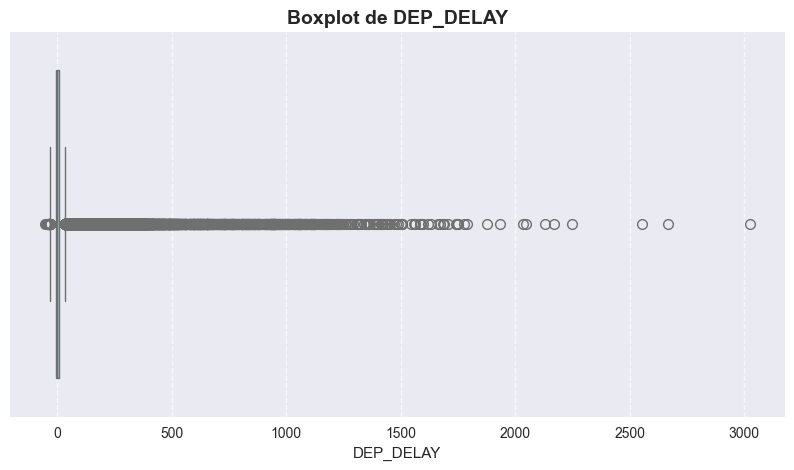

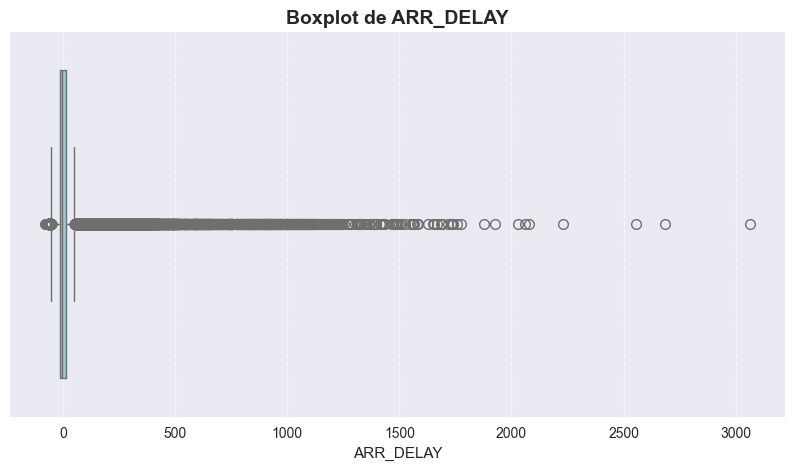

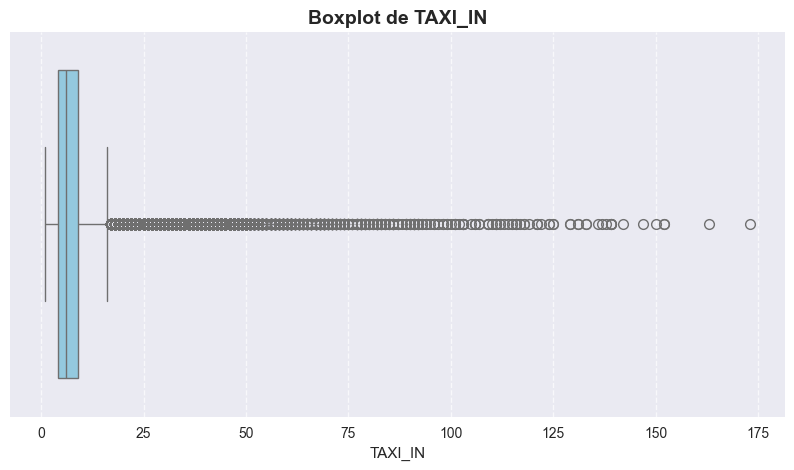

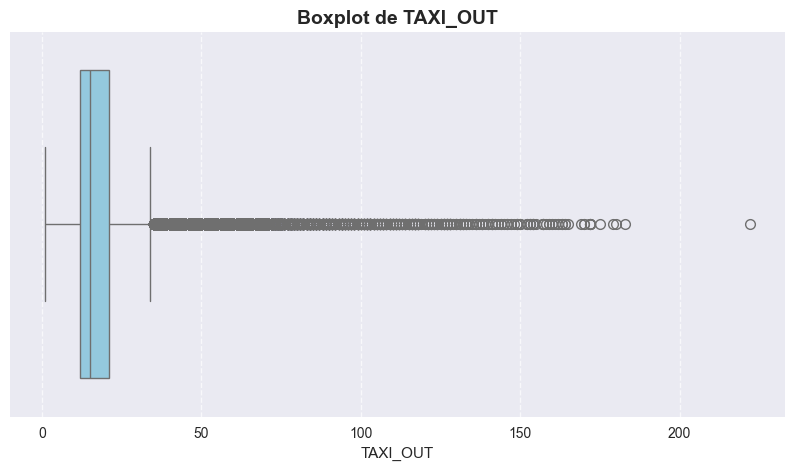

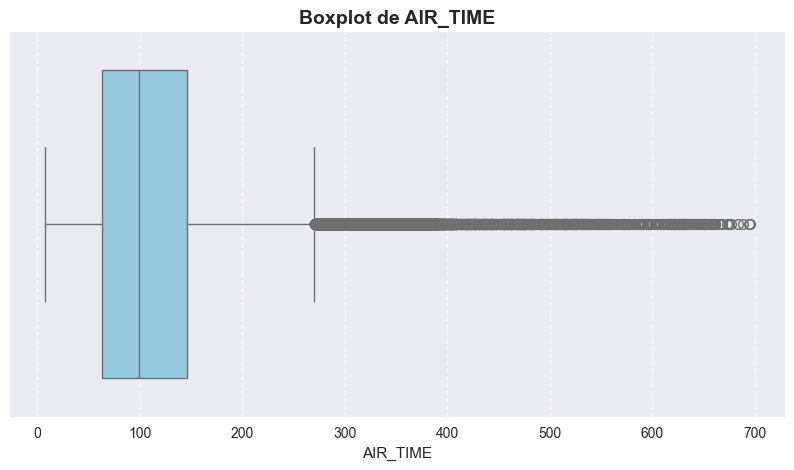

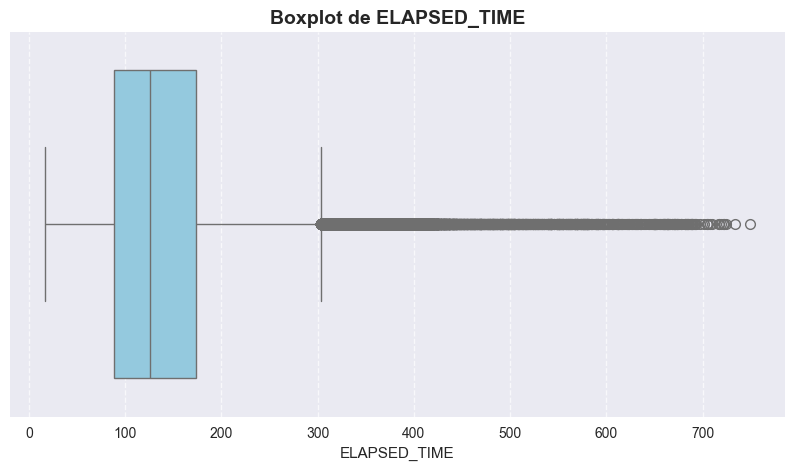

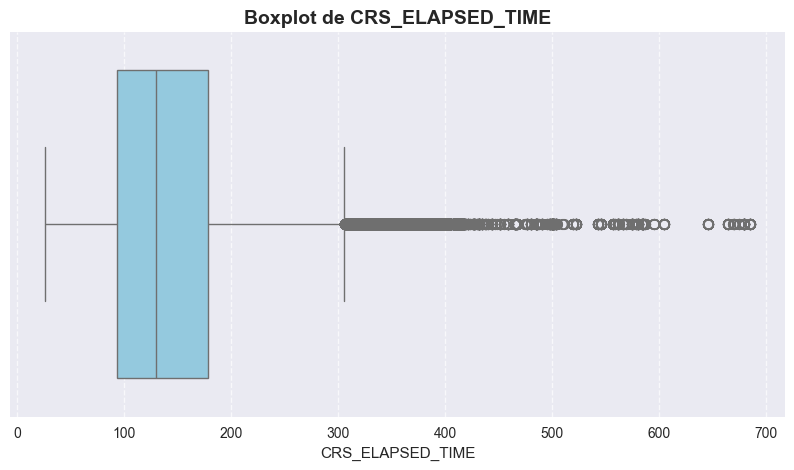

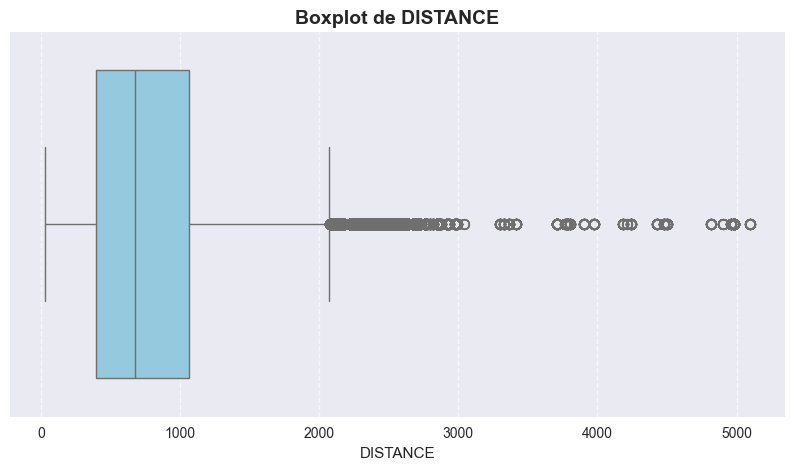

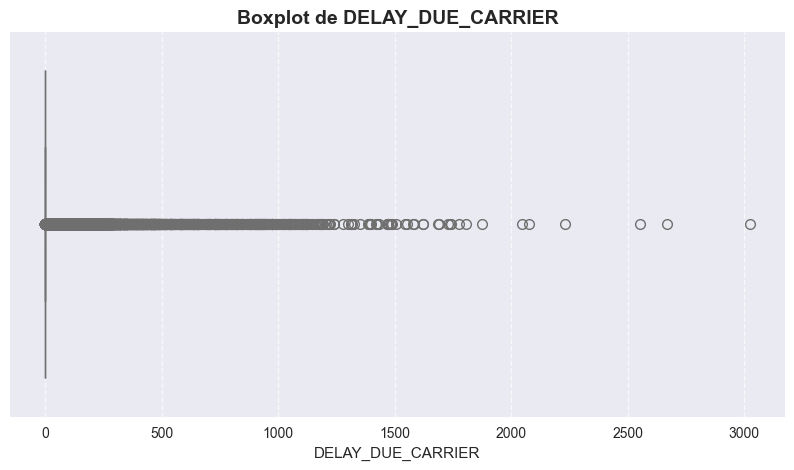

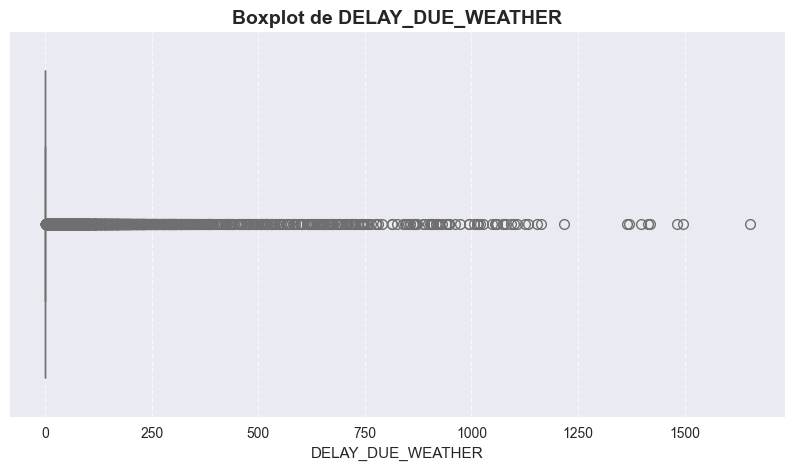

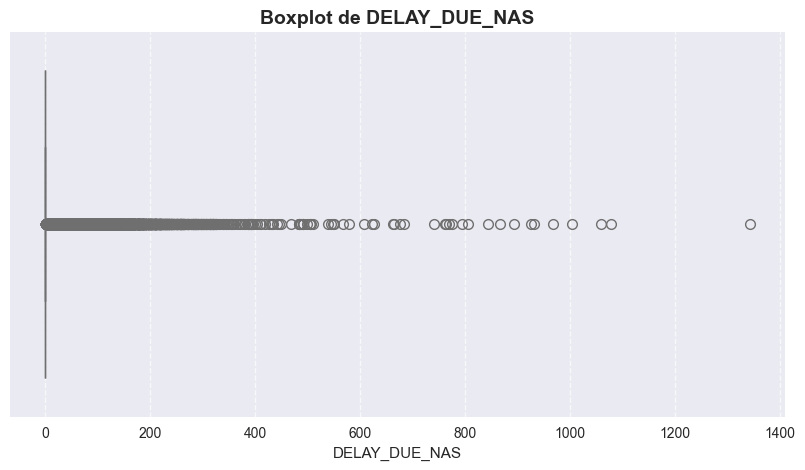

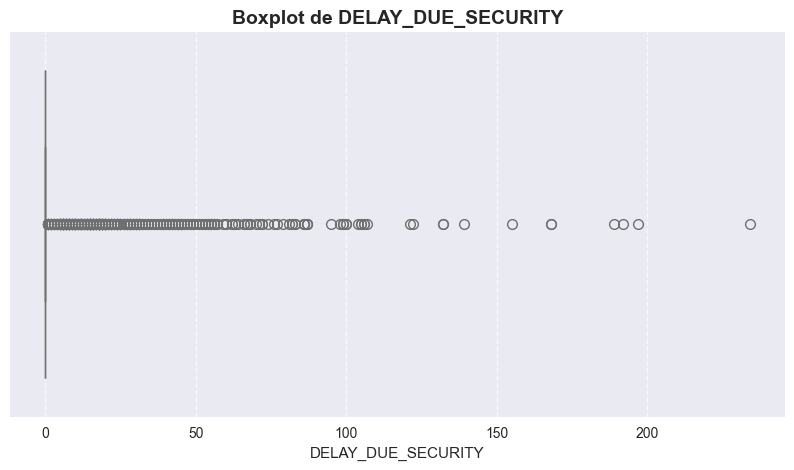

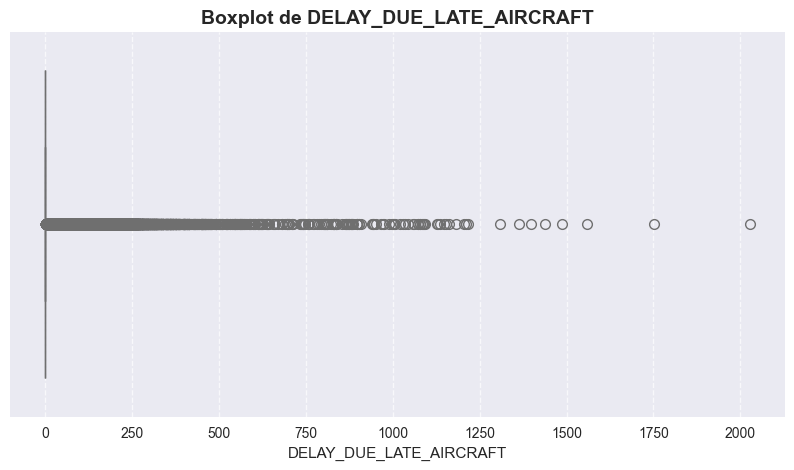

In [ ]:
# Configurações visuais
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Loop para criar boxplots de todas as colunas numéricas
for col in numeric_cols:
    if col in df_merged.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df_merged[col], color="skyblue")
        plt.title(f"Boxplot de {col}", fontsize=14, weight="bold")
        plt.xlabel(col)
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()

## 11. Análise Exploratória

11.1. Agrupar e visualizar dados de acordo com variáveis categóricas

In [ ]:
# Contagem de voos cancelados e desviados",
print("Voos Cancelados:")
print(df_merged["CANCELLED"] .sum())
print("Voos Desviados:")
print(df_merged["DIVERTED"] .sum())

In [ ]:
# Top 10 companhias aéreas com mais atrasos (considerando DEP_DELAY > 0)
top_delayed_airlines = df_merged[df_merged["DEP_DELAY"] > 0].groupby("AIRLINE_Description")["DEP_DELAY"] .count().nlargest(10)
print("Top 10 Companhias Aéreas com Mais Atrasos na Partida:")
print(top_delayed_airlines)

In [ ]:
# Média de atraso por companhia aérea
avg_delay_airline = df_merged.groupby("AIRLINE_Description")["DEP_DELAY"] .mean().sort_values(ascending=False)
print("Média de Atraso na Partida por Companhia Aérea:")
print(avg_delay_airline.head())

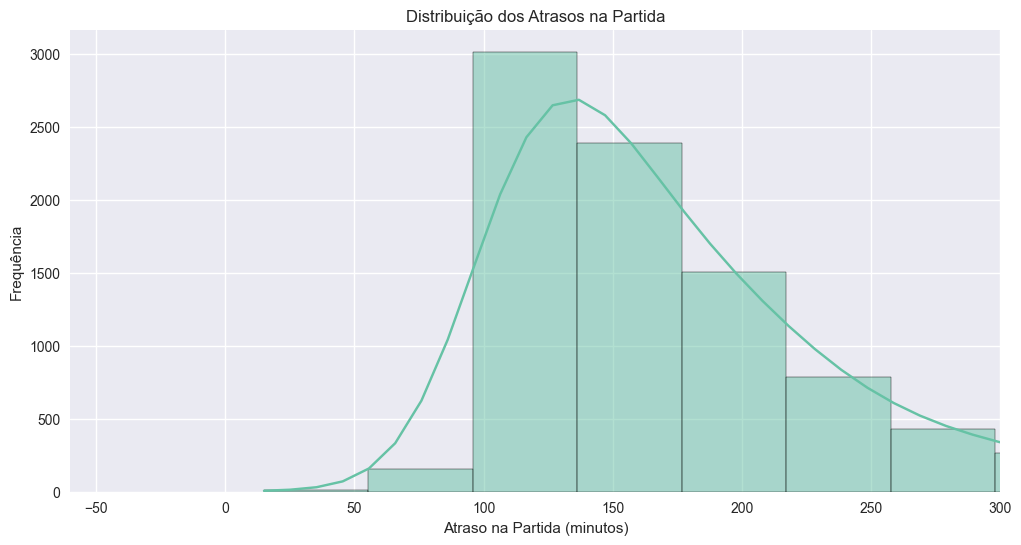

In [ ]:
# Distribuição dos atrasos

plt.figure(figsize=(12, 6))
sns.histplot(df["DEP_DELAY"] .dropna(), bins=50, kde=True)
plt.title("Distribuição dos Atrasos na Partida")
plt.xlabel("Atraso na Partida (minutos)")
plt.ylabel("Frequência")
plt.xlim(-60, 300) # Limitar o eixo x para melhor visualização de atrasos comuns
plt.show()

In [ ]:
# Atrasos por dia da semana (se FL_DATE foi convertida corretamente, podemos extrair o dia da semana)
df_merged["DAY_OF_WEEK"] = df_merged["FL_DATE"] .dt.day_name()
delay_by_day = df_merged.groupby("DAY_OF_WEEK")["DEP_DELAY"] .mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
print("Média de Atraso na Partida por Dia da Semana:")
print(delay_by_day)

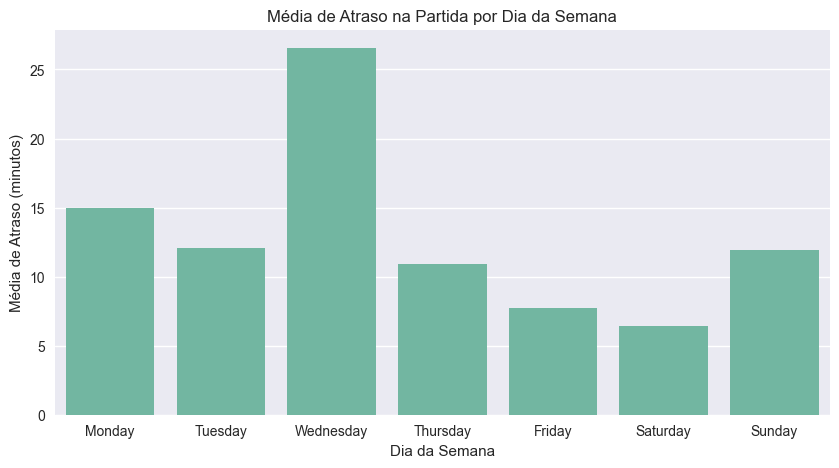

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=delay_by_day.index, y=delay_by_day.values)
plt.title("Média de Atraso na Partida por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Média de Atraso (minutos)")
plt.show()